In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
train = pd.read_csv('./data/mnist_train.csv')
test = pd.read_csv('./data/mnist_test.csv')

print(train.head())

train =train.to_numpy()
test =test.to_numpy()

train_x, train_y = train[:,1:].T, train[:,0]
test_x, test_y = test[:,1:].T, test[:,0]

#normalize data
train_x = train_x/255
test_x = test_x/255

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


# 1. Δημιουργία κλάσης νευρωνικού δικτύου τριών στρωμάτων

In [3]:
#batch sizes, size of hidden layer, lr, 2 or 3 layer 
class NeuralNetwork():
    
    def __init__(self,n_in,n_h,n_out):
        self.n_in = n_in
        self.n_h = n_h
        self.n_out = n_out
        self.W1,self.b1,self.W2,self.b2 = self.init_params()
        
    def init_params(self):
        n_input_layer = self.n_in
        n_hidden_layer = self.n_h
        n_output_layer = self.n_out
        
        W1 = np.random.rand(n_hidden_layer,n_input_layer) - 0.5 #[-0.5,0.5]
        b1 = np.random.rand(n_hidden_layer,1) - 0.5
        W2 = np.random.rand(n_output_layer,n_hidden_layer) - 0.5
        b2 = np.random.rand(n_output_layer,1) - 0.5
        return W1,b1,W2,b2
    
    def ReLU(self,Z):
        return np.maximum(Z,0) 

    def deriv_ReLU(self,Z):
        return Z > 0

    def softmax(self,Z):
        return np.exp(Z) / sum(np.exp(Z))
    
    def one_hot(self,Y):
        one_hot_y =  np.array(Y[:, None] == np.arange(10), np.float32)
        return one_hot_y.T

    def MSE(self, y, output):
         return np.square(np.subtract(y, output)).mean()
    
    def accuracy(self, y, output):
        return np.sum(output == y) / y.size
        
    def forward_propagation(self,W1,b1,W2,b2,X):
        Z1 = np.matmul(W1, X) + b1
        A1 = self.ReLU(Z1)
        Z2 = np.matmul(W2, A1) + b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2
    

    def back_propagation(self,Z1, A1, Z2, A2, W1, W2, X, Y):
        m = Y.size
        dZ2 = A2 - self.one_hot(Y)
        dW2 = 1./m * np.matmul(dZ2,A1.T)
        db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
        dA1 = np.matmul(W2.T,dZ2)
        dZ1 = dA1 * self.deriv_ReLU(Z1)
        dW1 = 1./m * np.matmul(dZ1,X.T)
        db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
        return dW1, db1, dW2, db2

    def update_parameters(self,W1, dW1, b1, db1, W2, dW2, b2, db2, learning_rate):
        W1 = W1 - learning_rate * dW1 
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2 
        b2 = b2 - learning_rate * db2
        return W1, b1, W2, b2
    
    def train(self,train_x,train_y,test_x,test_y,epochs=10,batch_size = 256,learning_rate=0.01):
        W1, b1, W2, b2 = self.init_params()
        train_accuracy = []
        train_loss = []
        test_accuracy = []
        test_loss = []
        
        start = time.time()
        for i in range(epochs):
            # Shuffle
            permutation = np.random.permutation(train_x.shape[1])
            train_x = train_x[:,permutation]
            train_y = train_y[permutation]
            
            num_batches = train_x.shape[1] // batch_size
            for j in range(num_batches):
                # Batch
                begin = j * batch_size
                end = min(begin + batch_size, train_x.shape[1]-1)
                x = train_x[:,begin:end]
                y = train_y[begin:end]
                Z1, A1, Z2, A2= self.forward_propagation(W1,b1,W2,b2,x)
                dW1, db1, dW2, db2 = self.back_propagation(Z1, A1, Z2, A2, W1, W2, x, y)
                W1, b1, W2, b2= self.update_parameters(W1, dW1, b1, db1, W2, dW2, b2, db2, learning_rate)
                
            #train data
            _,_,_,output = self.forward_propagation(W1,b1,W2,b2,train_x)
            predictions = np.argmax(output, 0)
            train_acc = self.accuracy(train_y,predictions)
            train_l = self.MSE(train_y, predictions)
            train_accuracy.append(train_acc)
            train_loss.append(train_l)
           
            #test data 
            _,_,_,output = self.forward_propagation(W1,b1,W2,b2,test_x)
            predictions = np.argmax(output, 0)
            test_acc = self.accuracy(test_y,predictions)
            test_l = self.MSE(test_y, predictions)
            test_accuracy.append(test_acc)
            test_loss.append(test_l)
            
        end = time.time()
        print('Run time = %.4f' % (end-start))
        print('Highest Accuracy achieved in the training model = %.4f' % train_accuracy[epochs-1])
        print('Lowest Loss achieved in the training model = %.4f' % train_loss[epochs-1])

        #plot results
        #Accuracy
        x = np.linspace(1,epochs,num=epochs)
        plt.plot(x,train_accuracy)
        plt.plot(x,test_accuracy)
        plt.title('[Model Accuracy] 3-Layer Neural Network with '+ str(self.n_h) + ' neurons \n in the hidden layer, batch size =' +str(batch_size) + ', learning rate =' + str(learning_rate))
        # plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid()
        plt.show()

        #Loss
        plt.plot(x,train_loss)
        plt.plot(x,test_loss)
        plt.title('[Model MSE] 3-Layer Neural Network with '+ str(self.n_h) + ' neurons \n in the hidden layer, batch size =' +str(batch_size) + ', learning rate =' + str(learning_rate))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid()
        plt.show()
        return predictions

# 2. Χρήση νευρωνικού δικτύου χωρίς μείωση διάστασης

Δοκιμή Διάφορων αριθμών νευρώνων στο κρυφό στρώμα

Run time = 50.2007
Highest Accuracy achieved in the training model = 0.9358
Lowest Loss achieved in the training model = 1.1032


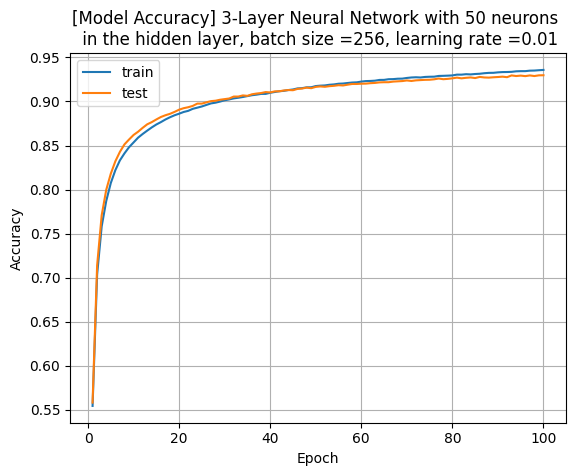

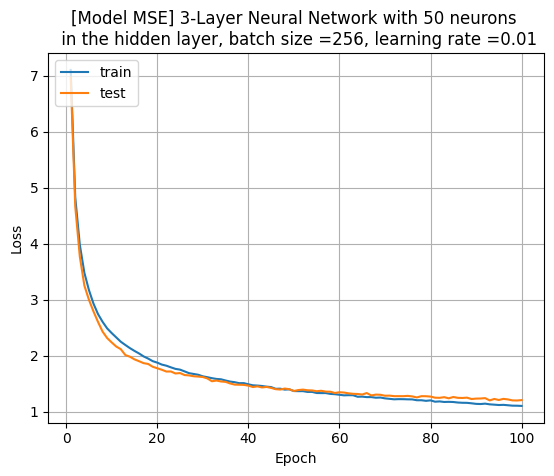

Run time = 87.9747
Highest Accuracy achieved in the training model = 0.9523
Lowest Loss achieved in the training model = 0.8046


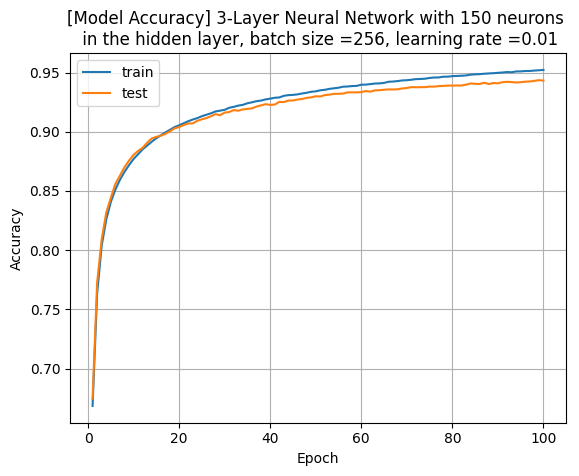

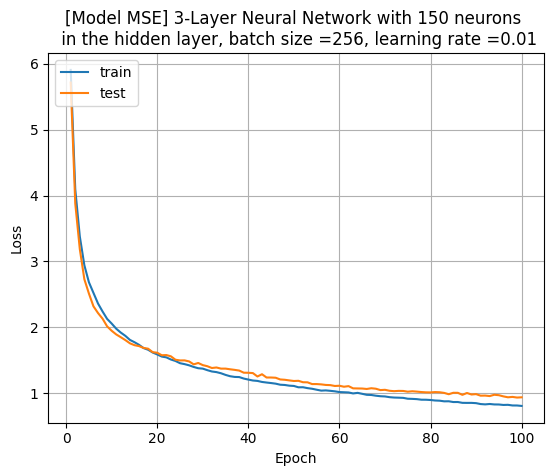

Run time = 132.5587
Highest Accuracy achieved in the training model = 0.9557
Lowest Loss achieved in the training model = 0.7475


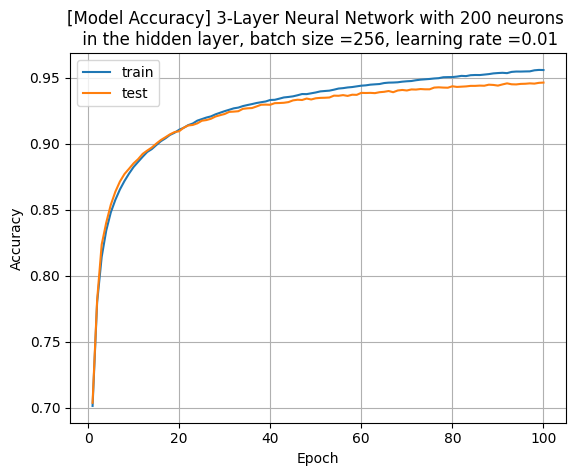

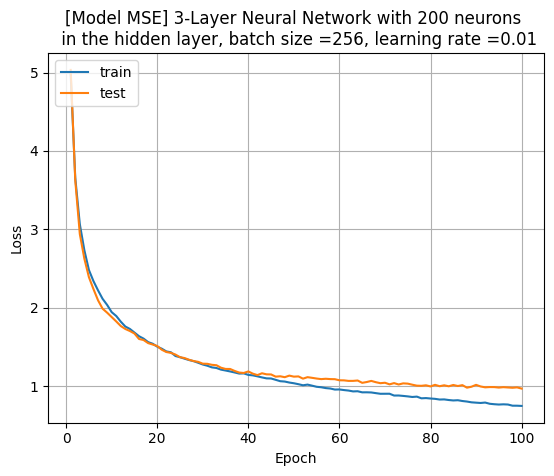

In [13]:
#default values
learning_rate = 0.01
n_h = 50
batch_size = 256
epochs = 100 

# testing number of neurons in the hidden layer 
num_of_neurons = [50, 150, 200]
for n_h in num_of_neurons:
    dnn = NeuralNetwork(784,n_h,10)
    predictions = dnn.train(train_x,train_y,test_x,test_y,epochs,batch_size,learning_rate)

Δοκιμή Διάφορων Batch Sizes

Run time = 95.7317
Highest Accuracy achieved in the training model = 0.9685
Lowest Loss achieved in the training model = 0.5743


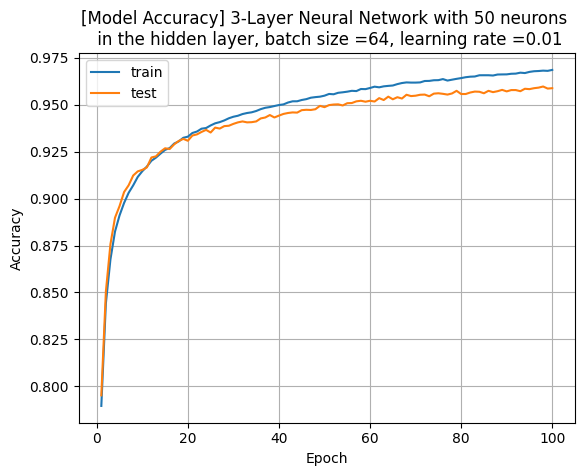

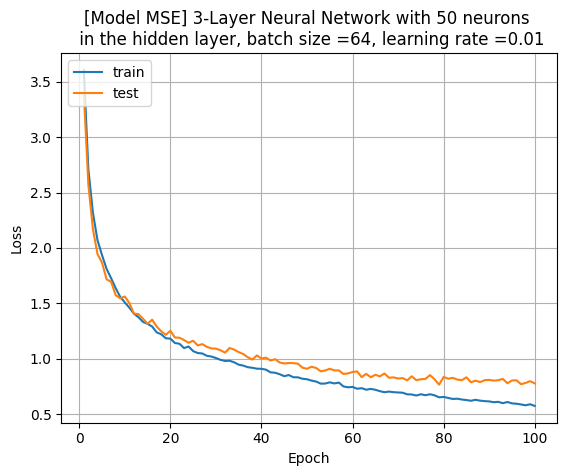

Run time = 60.5556
Highest Accuracy achieved in the training model = 0.9488
Lowest Loss achieved in the training model = 0.8957


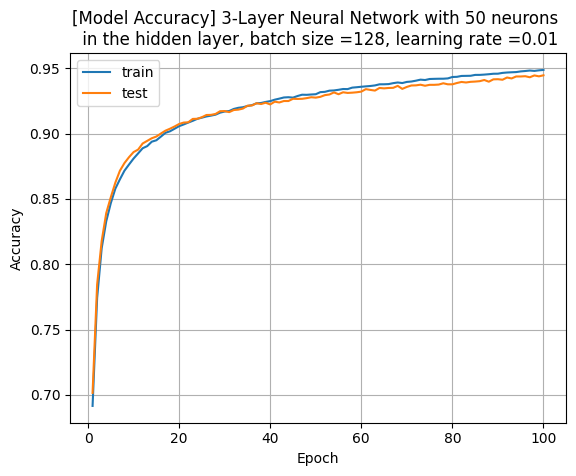

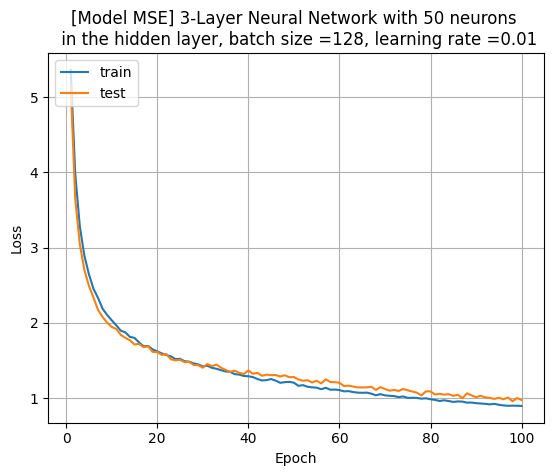

Run time = 50.6881
Highest Accuracy achieved in the training model = 0.9324
Lowest Loss achieved in the training model = 1.1927


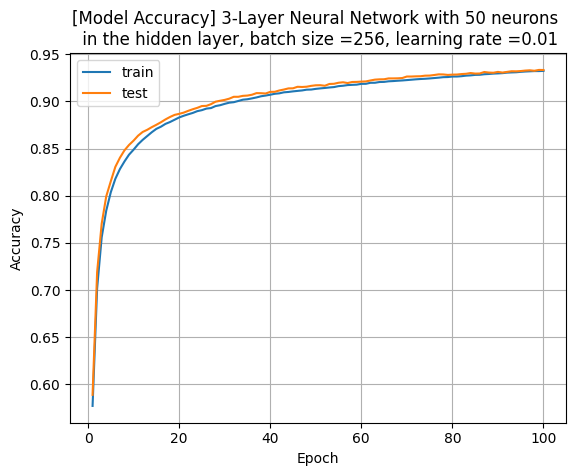

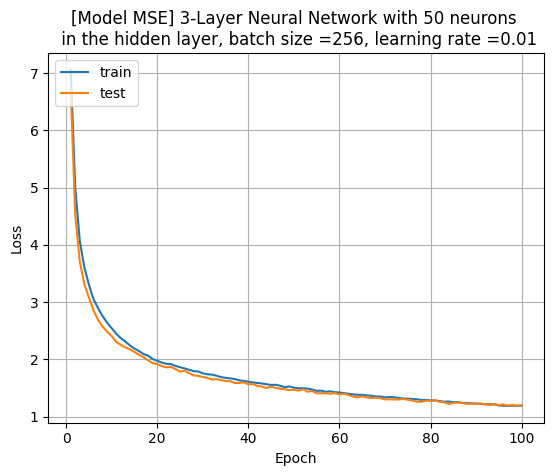

Run time = 46.3931
Highest Accuracy achieved in the training model = 0.4283
Lowest Loss achieved in the training model = 9.6323


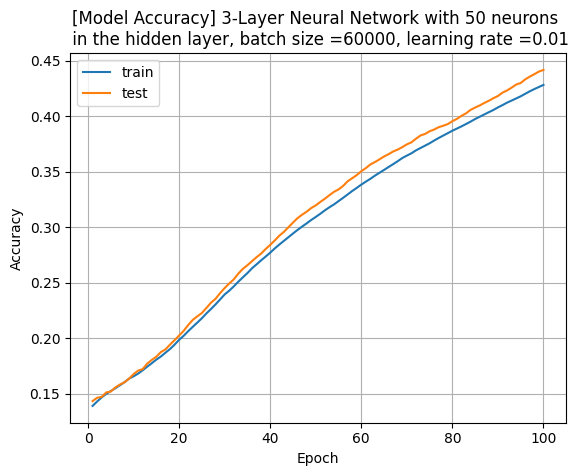

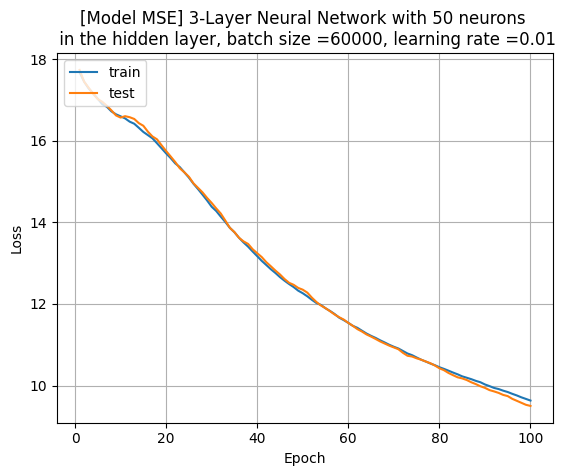

In [4]:
#default values
learning_rate = 0.01
n_h = 50
batch_size = 256
epochs = 100 

# testing different batch sizes
batch = [64, 128, 256, 60000]
for batch_size in batch:
    dnn = NeuralNetwork(784,n_h,10)
    predictions = dnn.train(train_x,train_y,test_x,test_y,epochs,batch_size,learning_rate)

 Δοκιμή Διάφορων learning rates

Run time = 49.6446
Highest Accuracy achieved in the training model = 0.9849
Lowest Loss achieved in the training model = 0.2871


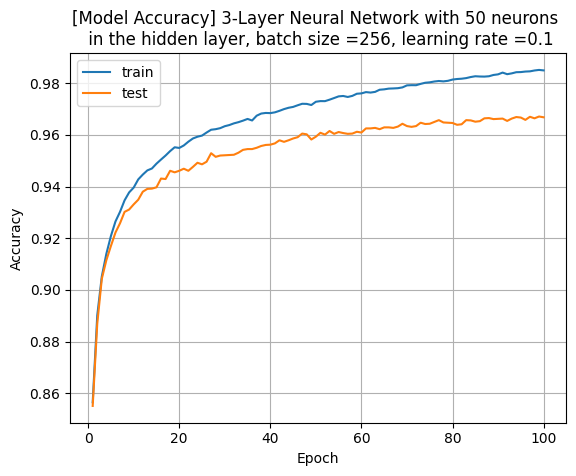

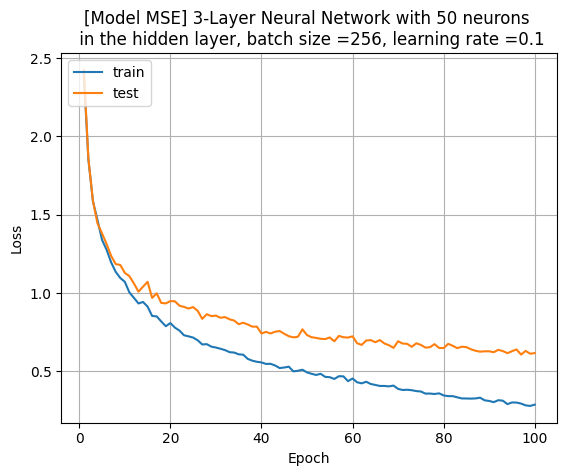

Run time = 47.8854
Highest Accuracy achieved in the training model = 0.9382
Lowest Loss achieved in the training model = 1.0863


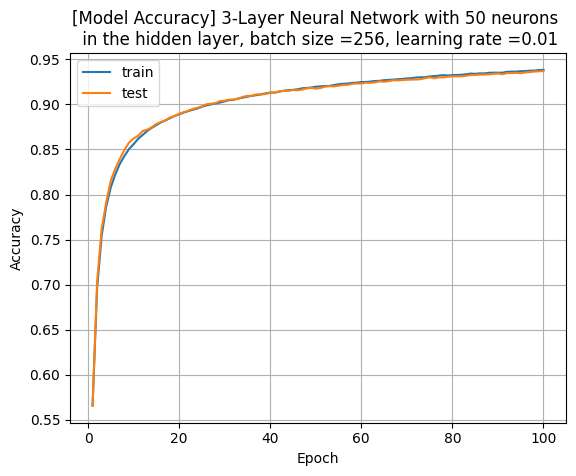

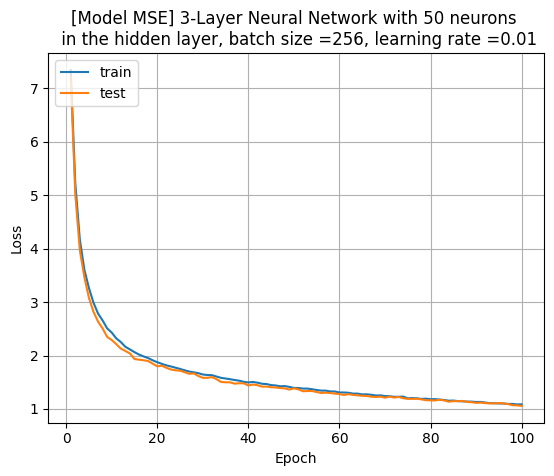

Run time = 50.6385
Highest Accuracy achieved in the training model = 0.8557
Lowest Loss achieved in the training model = 2.4318


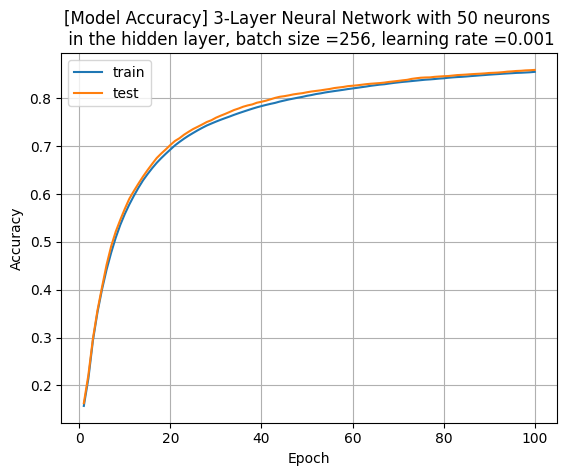

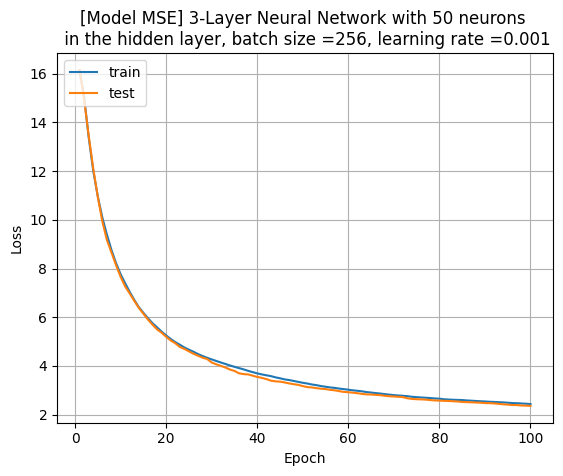

In [15]:
#default values
learning_rate = 0.01
n_h = 50
batch_size = 256
epochs = 100 

# testing different learning rates
lr = [0.1, 0.01, 0.001]
for learning_rate in lr:
    dnn = NeuralNetwork(784,n_h,10)
    predictions = dnn.train(train_x,train_y,test_x,test_y,epochs,batch_size,learning_rate)

# 3. Χρήση νευρωνικού δικτύου με μείωση διάστασης

Χρήση μέσης φωτεινότητας σειράς

In [14]:
train = pd.read_csv('./data/mnist_train.csv').to_numpy()
test = pd.read_csv('./data/mnist_test.csv').to_numpy()

train_x, train_y = train[:,1:].T, train[:,0]
test_x, test_y = test[:,1:].T, test[:,0]

#find mean of each row
train_x = np.mean(train_x.reshape(28,28,60000), axis=1)
test_x = np.mean(test_x.reshape(28,28,10000), axis=1)

#normalize data
train_x = train_x/255
test_x = test_x/255

Run time = 11.9861
Highest Accuracy achieved in the training model = 0.7233
Lowest Loss achieved in the training model = 5.1392


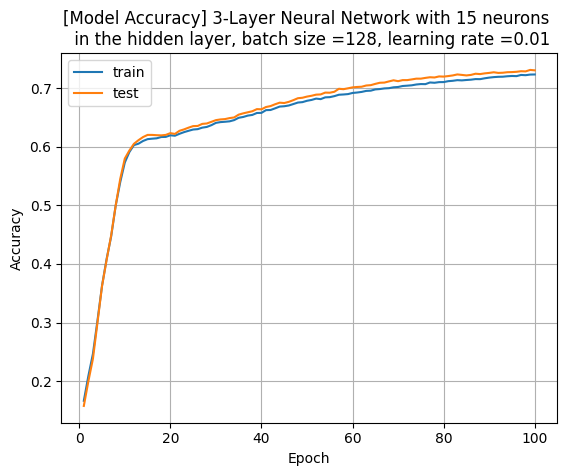

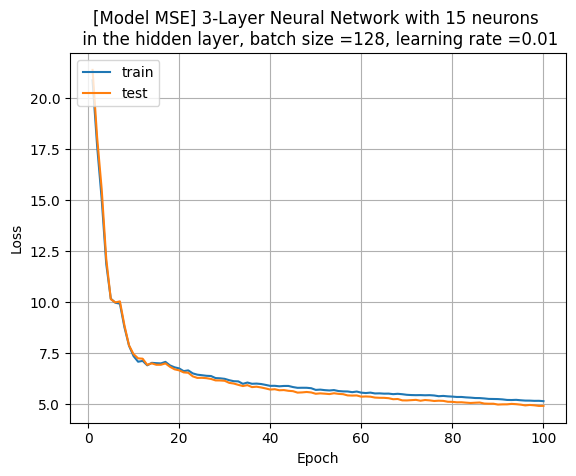

In [15]:
#default values
learning_rate = 0.01
n_h = 15
batch_size = 128
epochs = 100 

dnn = NeuralNetwork(28,n_h,10)
predictions = dnn.train(train_x,train_y,test_x,test_y,epochs,batch_size,learning_rate)

Μείωση Χαρακτηριστικών με τον αλγόριθμο PCA

In [22]:
train = pd.read_csv('./data/mnist_train.csv').to_numpy()
test = pd.read_csv('./data/mnist_test.csv').to_numpy()

train_x, train_y = train[:,1:].T, train[:,0]
test_x, test_y = test[:,1:].T, test[:,0]

In [18]:
def PCA(X,k):
    #Standardize the data
    X = (X - X.mean()) / X.std(ddof=0)

    # Calculating the correlation matrix of the data
    X_cov = np.dot(X, X.T)

    #Calculate eigenvalues and eigenvectors of the data
    eig_values, eig_vectors = np.linalg.eig(X_cov)

    #sort eigenvalues and eigenvectors
    ind = np.argsort(eig_values)[::-1]
    eig_values_sorted = eig_values[ind]
    eig_vectors_sorted = eig_vectors[:,ind]
    eig_vectors_subset = eig_vectors_sorted[:,0:k]
    total_explained_variance = np.sum(eig_values_sorted[0:k],axis=0).real
    X_reduced = np.dot(eig_vectors_subset.T , X)
    return X_reduced, total_explained_variance

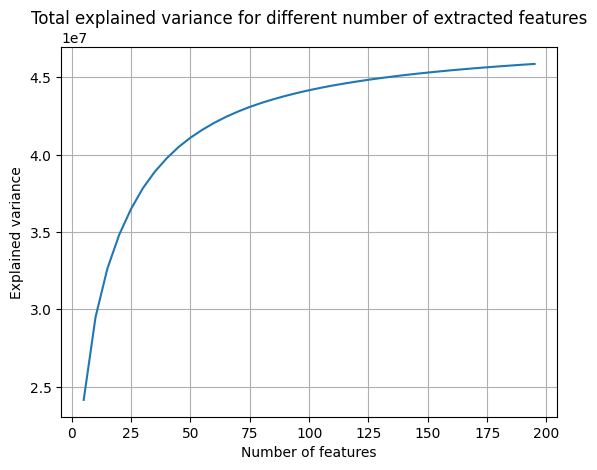

In [9]:
# find the appropriate number of extracted features 
num_of_features = np.arange(5,200,5)
exp_var = []
for k in num_of_features:
    _,var = PCA(train_x,k)
    exp_var.append(var)
plt.plot(num_of_features,exp_var)
plt.title('Total explained variance for different number of extracted features')
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.grid()
plt.show()

Run time = 96.7826
Highest Accuracy achieved in the training model = 0.9684
Lowest Loss achieved in the training model = 0.5571


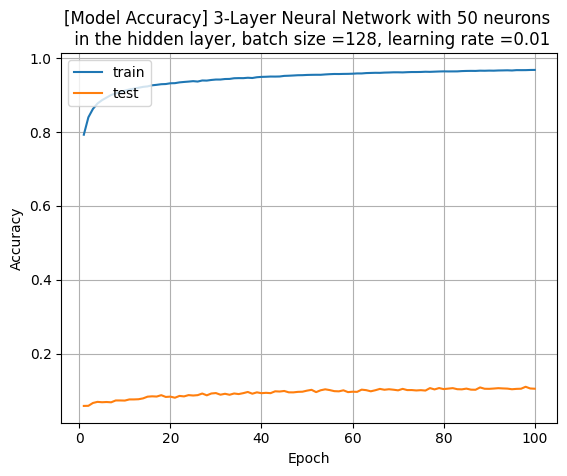

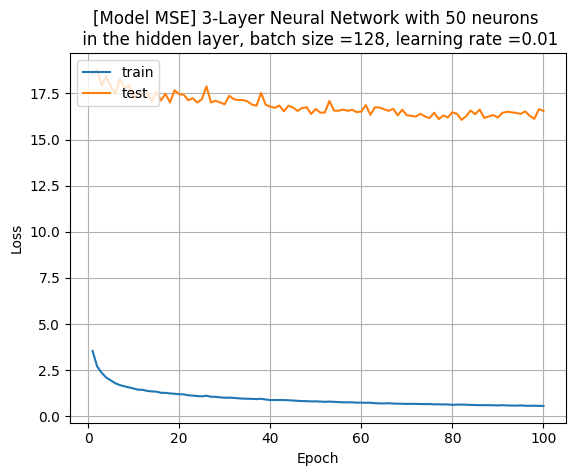

In [24]:
k = 125
train_x_PCA,_ = PCA(train_x,k)
test_x_PCA,_ = PCA(test_x,k)

learning_rate = 0.01
n_h = 50
batch_size = 128
epochs = 100 

dnn = NeuralNetwork(k,n_h,10)
predictions = dnn.train(train_x_PCA,train_y,test_x_PCA,test_y,epochs,batch_size,learning_rate)